In [2]:
import numpy as np
from abc import ABC, abstractmethod

class Problem(ABC):
    @abstractmethod
    def __call__(self, x: np.ndarray) -> float:
        """Compute the function value at point x."""
        raise NotImplementedError

    @abstractmethod
    def grad(self, x: np.ndarray) -> np.ndarray:
        """Compute the gradient at point x."""
        raise NotImplementedError

class Sphere(Problem):
    def __call__(self, x: np.ndarray) -> float:
        return np.sum(x**2)

    def grad(self, x: np.ndarray) -> np.ndarray:
        return 2 * x

class Rosenbrock(Problem):
    def __call__(self, x: np.ndarray) -> float:
        return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

    def grad(self, x: np.ndarray) -> np.ndarray:
        grad = np.zeros_like(x)
        n = x.size
        grad[0] = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
        for i in range(1, n - 1):
            grad[i] = 200 * (x[i] - x[i-1]**2) - 400 * x[i] * (x[i+1] - x[i]**2) - 2 * (1 - x[i])
        grad[-1] = 200 * (x[-1] - x[-2]**2)
        return grad

class Rastrigin(Problem):
    def __call__(self, x: np.ndarray) -> float:
        A = 10
        n = x.size
        return A * n + np.sum(x**2 - A * np.cos(2 * np.pi * x))

    def grad(self, x: np.ndarray) -> np.ndarray:
        A = 10
        return 2 * x + 2 * np.pi * A * np.sin(2 * np.pi * x)


In [3]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def prepare_mesh_grid(
    problem: Problem,
    bounds: tuple[float, float] = (-5.0, 5.0),
    grid_size: int = 50,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    x_vals = np.linspace(bounds[0], bounds[1], grid_size)
    y_vals = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)

    Z = np.zeros_like(X)
    for i in range(grid_size):
        for j in range(grid_size):
            xy = np.array([X[i, j], Y[i, j]])
            Z[i, j] = problem(xy)

    return X, Y, Z, x_vals, y_vals


def plot_3d_surface(
    problem: Problem,
    grid_size: int = 50,
):
    X, Y, Z, _, _ = prepare_mesh_grid(problem=problem, grid_size=grid_size)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="none")

    ax.set_title(problem.__class__.__name__)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x, y)")

    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.tight_layout()
    plt.show()

def plot_contour_and_paths(
    problem: Problem,
    paths: list[np.ndarray],
    grid_size: int = 200,
    title: str = "",
    labels: list[str] = None
):
    """
    Create an interactive contour plot of a 2D function and overlay multiple optimization paths.

    Args:
        problem: An instance of a Problem class.
        paths: List of numpy arrays; each array is of shape (epochs, 2) containing an optimization trajectory.
        title: Title for the plot.
    """
    _, _, Z, x_vals, y_vals = prepare_mesh_grid(problem, grid_size=grid_size)

    fig = go.Figure(
        data=go.Contour(
            x=x_vals,
            y=y_vals,
            z=Z+1e-10,
            colorscale="Turbo",
            contours=dict(
                showlines=False,
            ),
            colorbar=dict(title="Function Value"),
            ncontours=80,
        )
    )

    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'pink', 'brown']

    for idx, path in enumerate(paths):
        color_idx = idx % len(colors)
        label = labels[idx] if labels else f"Run {idx+1}"
        fig.add_trace(
            go.Scatter(
                x=path[:, 0],
                y=path[:, 1],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(width=2, color=colors[color_idx]),
                showlegend=True,
                name=label
            )
        )

    fig.update_layout(
        title=title, xaxis_title="x", yaxis_title="y", width=800, height=700,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.show()

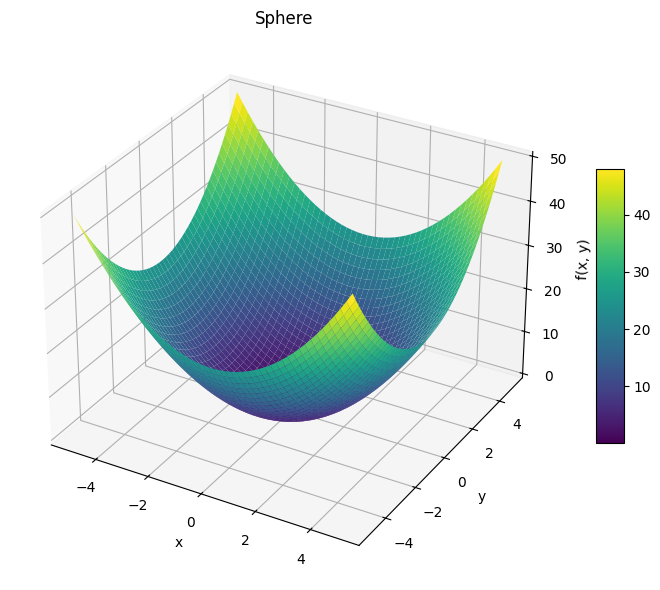

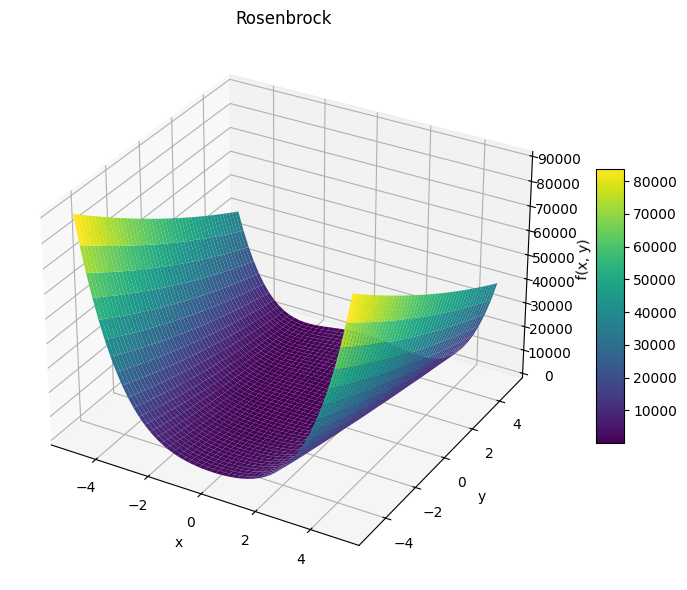

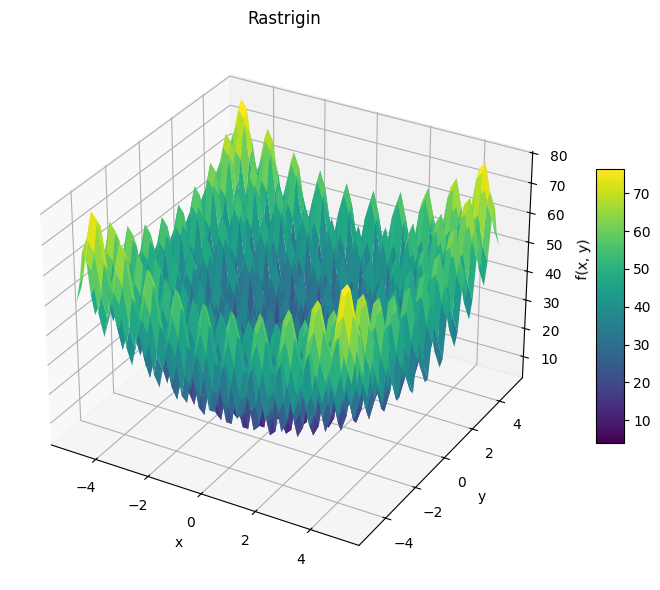

In [4]:
# Create instances of the problems
sphere_problem = Sphere()
rosenbrock_problem = Rosenbrock()
rastrigin_problem = Rastrigin()

# Plot 3D surface for each function
plot_3d_surface(sphere_problem)
plot_3d_surface(rosenbrock_problem)
plot_3d_surface(rastrigin_problem)


In [5]:
# Example paths
sphere_paths = [np.array([[i, i] for i in range(10)])]
rosenbrock_paths = [np.array([[i, 0] for i in range(10)])]
rastrigin_paths = [np.array([[i, -i] for i in range(10)])]

# Plot contour for example paths
plot_contour_and_paths(sphere_problem, sphere_paths, title="Sphere Function Optimization")
plot_contour_and_paths(rosenbrock_problem, rosenbrock_paths, title="Rosenbrock Function Optimization")
plot_contour_and_paths(rastrigin_problem, rastrigin_paths, title="Rastrigin Function Optimization")

In [6]:
def momentum_optimizer(
    problem: Problem,
    initial_solution: np.ndarray,
    alpha: float,
    beta: float,
    number_of_epochs: int,
):
    velocity = np.zeros_like(initial_solution)
    weights = initial_solution.copy()
    weights_array = [weights.copy()]

    for epoch in range(number_of_epochs):
        velocity = beta * velocity + alpha * problem.grad(weights)
        weights = weights - velocity
        weights_array.append(weights.copy())

    return np.array(weights_array)


initial_solution = np.array([2.0, 2.0]) # Starting point
alpha = 0.01 # Learning rate
beta = 0.9 # Momentum_optimizer parameter
number_of_epochs = 100

# Optimization paths for given functions
sphere_paths = [momentum_optimizer(sphere_problem, initial_solution, alpha, beta, number_of_epochs)]

alpha = 0.001 # Set lower learning rate
rosenbrock_paths = [momentum_optimizer(rosenbrock_problem, initial_solution, alpha, beta, number_of_epochs)]
rastrigin_paths = [momentum_optimizer(rastrigin_problem, initial_solution, alpha, beta, number_of_epochs)]

# Plot contour and optimization paths for each function
plot_contour_and_paths(sphere_problem, sphere_paths, title="Sphere Function Optimization")
plot_contour_and_paths(rosenbrock_problem, rosenbrock_paths, title="Rosenbrock Function Optimization")
plot_contour_and_paths(rastrigin_problem, rastrigin_paths, title="Rastrigin Function Optimization")

In [7]:
# Define hyperparameters
betas = [0.5, 0.75, 0.9, 0.95, 0.99]
alpha = 1e-4
initial_solution = np.array([2.0, 2.0])
epochs = 100

# Generate paths for each beta
rosenbrock_paths = []
for beta in betas:
    path = momentum_optimizer(rosenbrock_problem, initial_solution, alpha, beta, epochs)
    rosenbrock_paths.append(path)

# Create labels
labels = [f"β = {beta}" for beta in betas]

# Plot results
plot_contour_and_paths(
    rosenbrock_problem,
    rosenbrock_paths,
    title=f"Rosenbrock Optimization with Momentum (α={alpha})",
    labels=labels
)

In [9]:
def adam(
    problem: Problem,
    initial_solution: np.ndarray,
    alpha: float,
    beta1: float,
    beta2: float,
    number_of_epochs: int,
    epsilon: float = 1e-8,
):
    m = np.zeros_like(initial_solution)
    v = np.zeros_like(initial_solution)
    weights = initial_solution.copy()
    weights_array = [weights.copy()]

    for epoch in range(1, number_of_epochs + 1):
        grad = problem.grad(weights)

        # First and second momentum
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        # Bias correction
        m_hat = m / (1 - beta1 ** epoch)
        v_hat = v / (1 - beta2 ** epoch)

        # Parameters update
        weights = weights - alpha * m_hat / (np.sqrt(v_hat) + epsilon)
        weights_array.append(weights.copy())

    return np.array(weights_array)

In [33]:
number_of_epochs = 100
initial_solution = np.array([2.0, 2.0])

# Momentum parameters
m_alpha = 0.01
m_beta = 0.9

# Adam parameters
a_alpha = 0.1
a_beta1 = 0.9
a_beta2 = 0.999
epsilon = 1e-8

# Calculate paths for both optimizers
sphere_paths_momentum = momentum_optimizer(sphere_problem, initial_solution,
                                           m_alpha, m_beta, number_of_epochs)
rosenbrock_paths_momentum = momentum_optimizer(rosenbrock_problem, initial_solution,
                                               m_alpha, m_beta, number_of_epochs)
rastrigin_paths_momentum = momentum_optimizer(rastrigin_problem, initial_solution,
                                              m_alpha, m_beta, number_of_epochs)

sphere_paths_adam = adam(sphere_problem, initial_solution, a_alpha, a_beta1, a_beta2,
                         number_of_epochs, epsilon)
rosenbrock_paths_adam = adam(rosenbrock_problem, initial_solution, a_alpha, a_beta1, a_beta2,
                             number_of_epochs, epsilon)
rastrigin_paths_adam = adam(rastrigin_problem, initial_solution, a_alpha, a_beta1, a_beta2,
                            number_of_epochs, epsilon)

sphere_paths = [sphere_paths_momentum, sphere_paths_adam]
rosenbrock_paths = [rosenbrock_paths_momentum, rosenbrock_paths_adam]
rastrigin_paths = [rastrigin_paths_momentum, rastrigin_paths_adam]

# Create labels
labels = ["Optimizer: Momentum", "Optimizer: Adam"]

plot_contour_and_paths(sphere_problem, sphere_paths,
                       title="Sphere Function Optimization", labels=labels)
plot_contour_and_paths(rastrigin_problem, rastrigin_paths,
                       title="Rastrigin Function Optimization", labels=labels)
plot_contour_and_paths(rosenbrock_problem, rosenbrock_paths,
                       title="Rosenbrock Function Optimization", labels=labels)

/tmp/ipykernel_4054/4269148045.py:29: RuntimeWarning:

overflow encountered in scalar multiply

/tmp/ipykernel_4054/3341384468.py:13: RuntimeWarning:

invalid value encountered in add



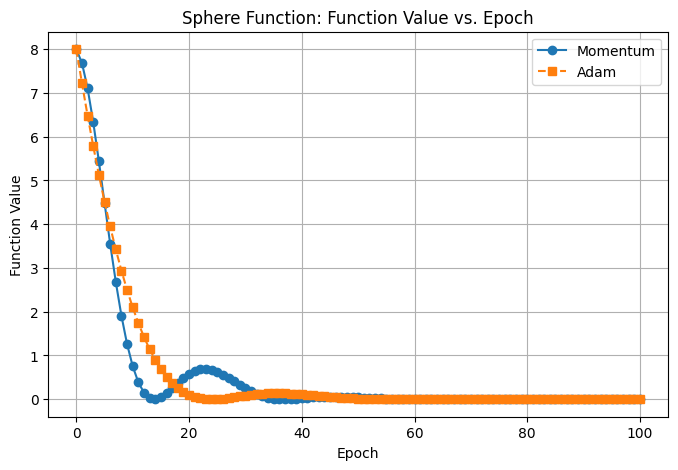

/tmp/ipykernel_4054/4269148045.py:24: RuntimeWarning:

overflow encountered in square



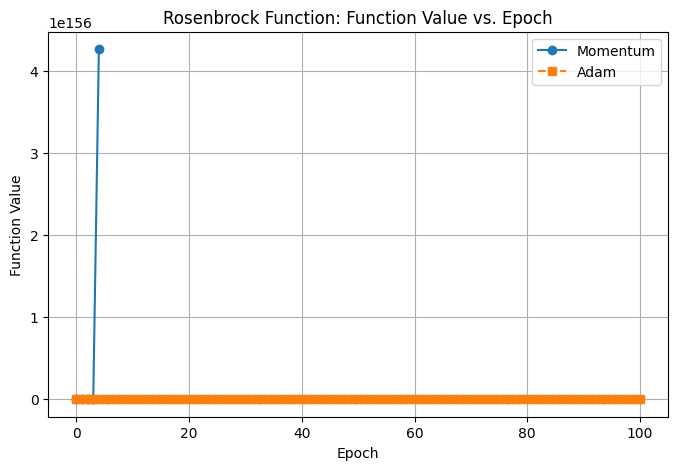

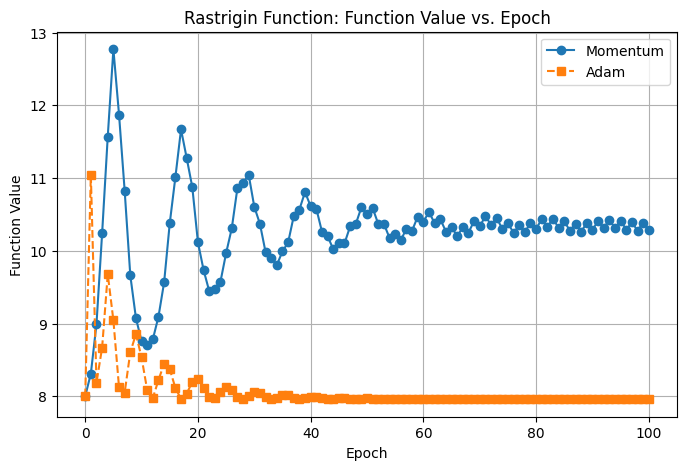

In [32]:
def plot_function_values(problem, momentum_path, adam_path, title):
    # Create an array of epochs (assumes paths have the same length)
    epochs = np.arange(len(momentum_path))

    # Compute function values for each optimizer at every epoch
    momentum_values = [problem(x) for x in momentum_path]
    adam_values = [problem(x) for x in adam_path]

    # Plot the function values vs. epoch
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, momentum_values, label="Momentum", marker='o', linestyle='-')
    plt.plot(epochs, adam_values, label="Adam", marker='s', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Function Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for each problem:
plot_function_values(sphere_problem, sphere_paths_momentum, sphere_paths_adam,
                     "Sphere Function: Function Value vs. Epoch")
plot_function_values(rosenbrock_problem, rosenbrock_paths_momentum, rosenbrock_paths_adam,
                     "Rosenbrock Function: Function Value vs. Epoch")
plot_function_values(rastrigin_problem, rastrigin_paths_momentum, rastrigin_paths_adam,
                     "Rastrigin Function: Function Value vs. Epoch")